In [4]:
import pandas as pd

df = pd.read_csv('/content/GlobalWeatherRepository.csv')
df.head()


,country,location_name,latitude,longitude,timezone,last_updated_epoch,last_updated,temperature_celsius,temperature_fahrenheit,condition_text,...,air_quality_PM2.5,air_quality_PM10,air_quality_us-epa-index,air_quality_gb-defra-index,sunrise,sunset,moonrise,moonset,moon_phase,moon_illumination
0,Afghanistan,Kabul,34.52,69.18,Asia/Kabul,1715849100,2024-05-16 13:15,26.6,79.8,Partly Cloudy,...,8.4,26.6,1,1,04:50 AM,06:50 PM,12:12 PM,01:11 AM,Waxing Gibbous,55
1,Albania,Tirana,41.33,19.82,Europe/Tirane,1715849100,2024-05-16 10:45,19.0,66.2,Partly cloudy,...,1.1,2.0,1,1,05:21 AM,07:54 PM,12:58 PM,02:14 AM,Waxing Gibbous,55
2,Algeria,Algiers,36.76,3.05,Africa/Algiers,1715849100,2024-05-16 09:45,23.0,73.4,Sunny,...,10.4,18.4,1,1,05:40 AM,07:50 PM,01:15 PM,02:14 AM,Waxing Gibbous,55
3,Andorra,Andorra La Vella,42.50,1.52,Europe/Andorra,1715849100,2024-05-16 10:45,6.3,43.3,Light drizzle,...,0.7,0.9,1,1,06:31 AM,09:11 PM,02:12 PM,03:31 AM,Waxing Gibbous,55
4,Angola,Luanda,-8.84,13.23,Africa/Luanda,1715849100,2024-05-16 09:45,26.0,78.8,Partly cloudy,...,183.4,262.3,5,10,06:12 AM,05:55 PM,01:17 PM,12:38 AM,Waxing Gibbous,55


Data Cleaning & Preprocessing

In [5]:
# Handle Missing Values

#Summary of nulls
df.isnull().sum()

#Fill or drop missing values (based on importance)
df.fillna(method='ffill', inplace=True)  # forward fill
#or: df.dropna(inplace=True)


<ipython-input-5-c24656e98b71>:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)  # forward fill


In [6]:
#Outlier Detection (e.g., Z-score)

from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
df_clean = df[(z_scores < 3).all(axis=1)]


In [7]:
#Normalize Data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numerical = df_clean.select_dtypes(include=['float64', 'int64'])
scaled_data = scaler.fit_transform(numerical)
scaled_df = pd.DataFrame(scaled_data, columns=numerical.columns)


Exploratory Data Analysis (EDA)


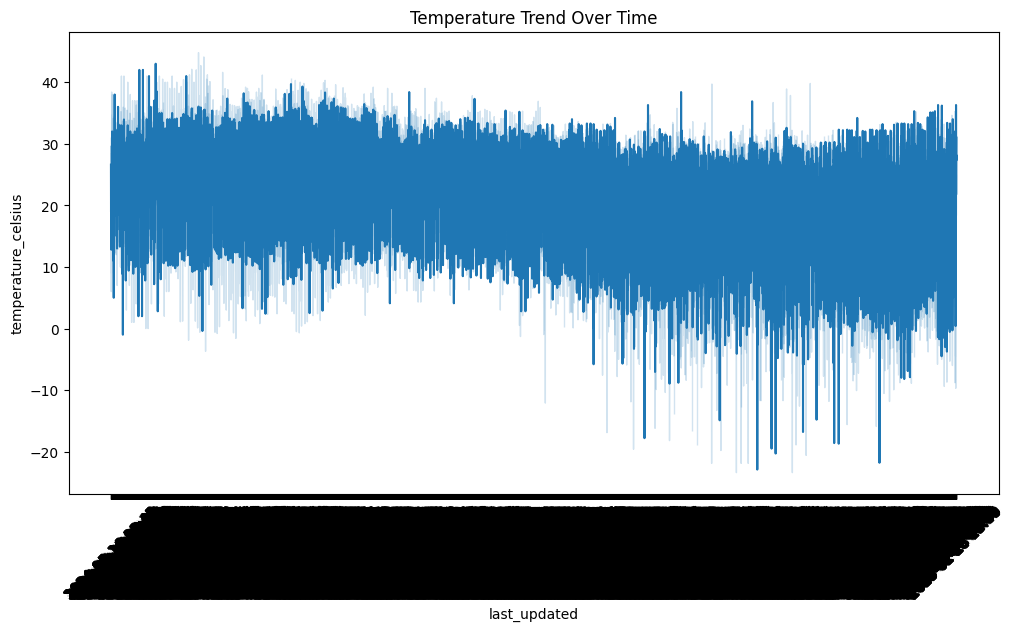

In [10]:
#Temperature Trends
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='last_updated', y='temperature_celsius')
plt.title('Temperature Trend Over Time')
plt.xticks(rotation=45)
plt.show()


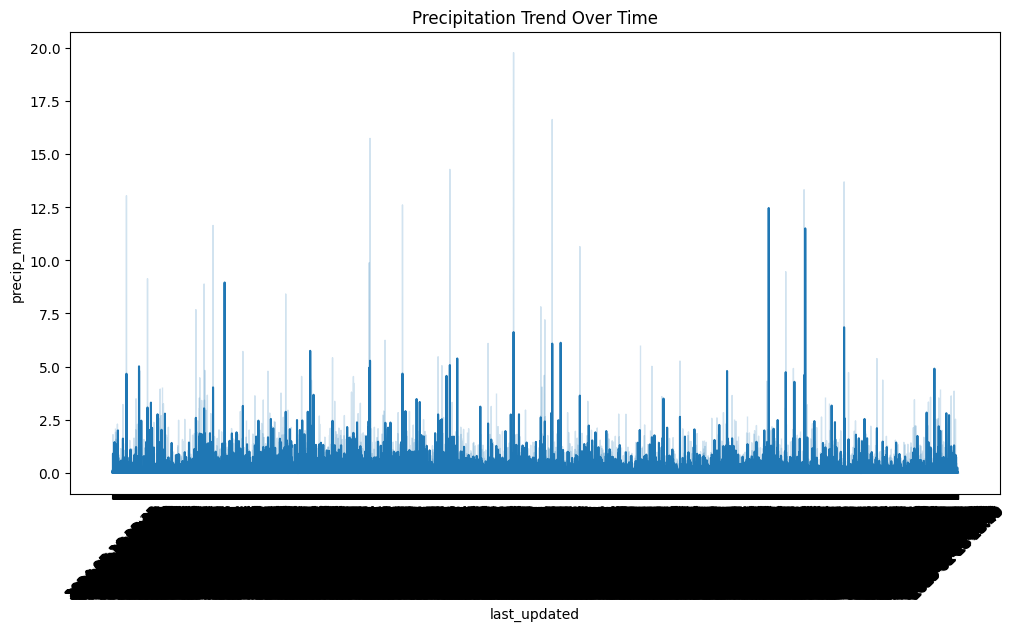

In [11]:
#Precipitation Trends
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='last_updated', y='precip_mm')
plt.title('Precipitation Trend Over Time')
plt.xticks(rotation=45)
plt.show()


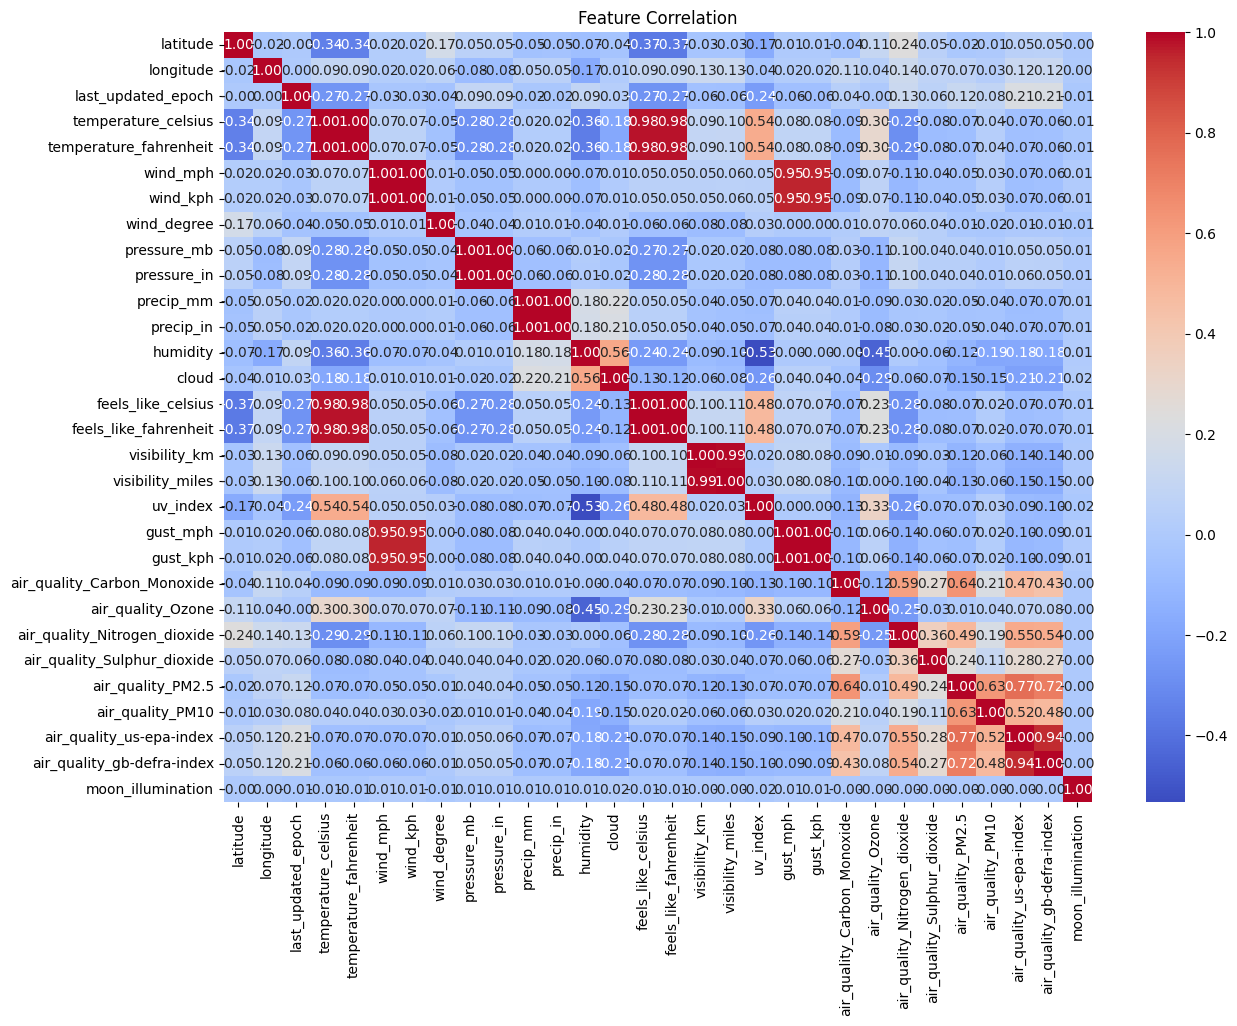

In [12]:
#Correlation Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, fmt=".2f", cmap="coolwarm") # Select only numerical features for correlation
plt.title('Feature Correlation')
plt.show()

Time Series Forecasting Model

In [8]:
# Prepare Data

df['last_updated'] = pd.to_datetime(df['last_updated'])
df.set_index('last_updated', inplace=True)
ts = df['temperature_celsius'].resample('D').mean()  # Daily avg temp
ts = ts.fillna(method='ffill')


<ipython-input-8-fa178c31a93e>:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


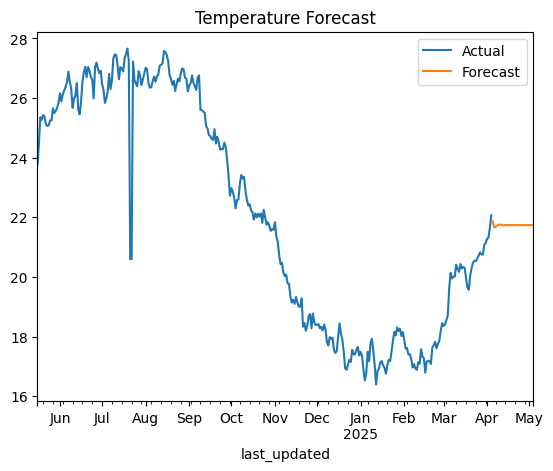

In [11]:
#Forecast using ARIMA (basic model)

from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
model = ARIMA(ts, order=(5,1,0))
model_fit = model.fit()
forecast = model_fit.forecast(steps=30)

#Plot
ts.plot(label='Actual')
forecast.plot(label='Forecast')
plt.legend()
plt.title("Temperature Forecast")
plt.show()


In [12]:
# Evaluate Model

from sklearn.metrics import mean_squared_error

pred = model_fit.predict(start=0, end=len(ts)-1, dynamic=False)
mse = mean_squared_error(ts, pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2.041159534548533


 Optional: Save Report / Export

In [13]:
# Save cleaned dataset
df_clean.to_csv("cleaned_weather_data.csv", index=False)


Advanced EDA – Anomaly Detection


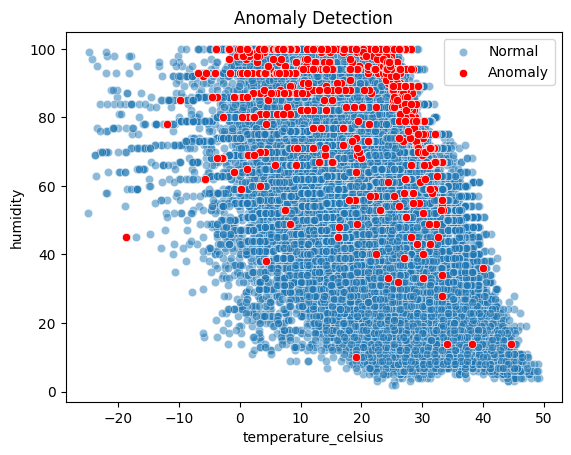

In [15]:
#Example (Isolation Forest)

from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

#Using selected features
features = df[['temperature_celsius', 'precip_mm', 'humidity', 'wind_kph']]
clf = IsolationForest(contamination=0.01)
df['anomaly'] = clf.fit_predict(features)

#Plot anomalies
anomalies = df[df['anomaly'] == -1]
sns.scatterplot(data=df, x='temperature_celsius', y='humidity', label='Normal', alpha=0.5)
sns.scatterplot(data=anomalies, x='temperature_celsius', y='humidity', color='red', label='Anomaly')
plt.title("Anomaly Detection")
plt.show()


In [24]:
df = df.reset_index()

In [25]:
import pandas as pd

df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values('last_updated')

# Aggregate to daily average temp (if multiple rows per day)
daily_temp = df.groupby('last_updated')['temperature_celsius'].mean()

# Create the time series
ts = daily_temp.asfreq('D')  # Enforce daily frequency
ts = ts.fillna(method='ffill')  # Fill missing dates


<ipython-input-25-e36f27c3c89d>:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')  # Fill missing dates


In [26]:
print(df.columns.tolist())


['last_updated', 'country', 'location_name', 'latitude', 'longitude', 'timezone', 'last_updated_epoch', 'temperature_celsius', 'temperature_fahrenheit', 'condition_text', 'wind_mph', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'pressure_in', 'precip_mm', 'precip_in', 'humidity', 'cloud', 'feels_like_celsius', 'feels_like_fahrenheit', 'visibility_km', 'visibility_miles', 'uv_index', 'gust_mph', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'air_quality_PM10', 'air_quality_us-epa-index', 'air_quality_gb-defra-index', 'sunrise', 'sunset', 'moonrise', 'moonset', 'moon_phase', 'moon_illumination', 'anomaly']


 Forecasting with Multiple Models

<ipython-input-30-0fc6e19b7bdc>:14: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = daily_temp.asfreq('D').fillna(method='ffill')
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpruai2140/d3sxn_0f.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpruai2140/sb6q4omf.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2588', 'data', 'file=/tmp/tmpruai2140/d3sxn_0f.json', 'init=/tmp/tmpruai2140/sb6q4omf.json', 'output', 'file=/tmp/tmpruai2140/prophet_modelt9v1d1_7/prophet_model-20250407090414.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:04:14 - cmds

MAE ARIMA:    0.249
MAE Prophet:  1.5
MAE Naive:    0.189
MAE Ensemble: 0.611


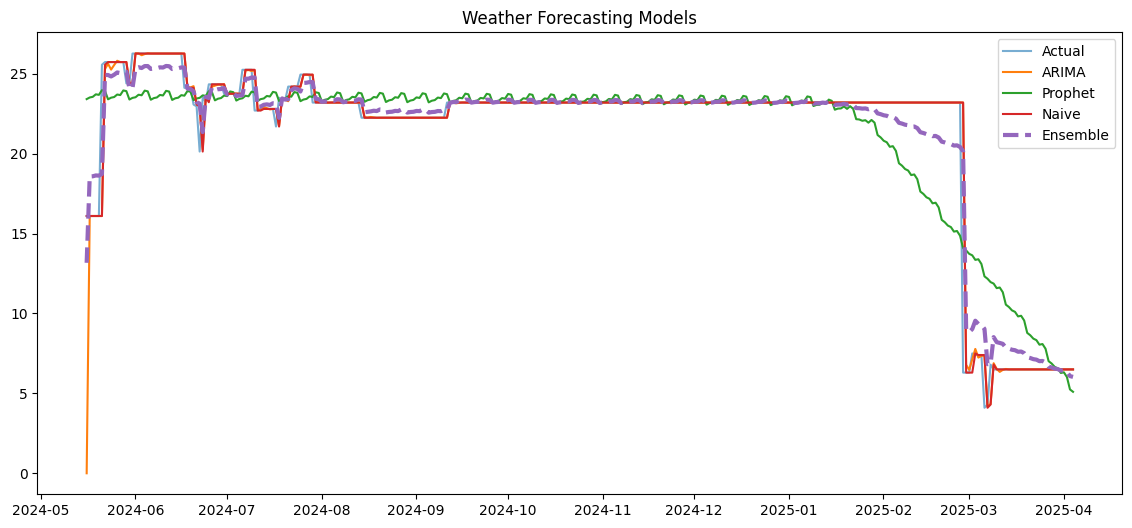

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
from prophet import Prophet

#Load and preprocess
df = pd.read_csv("/content/GlobalWeatherRepository.csv")
df.columns = df.columns.str.strip()
df['last_updated'] = pd.to_datetime(df['last_updated'])
df = df.sort_values('last_updated')
daily_temp = df.groupby('last_updated')['temperature_celsius'].mean()
ts = daily_temp.asfreq('D').fillna(method='ffill')

# Model 1: ARIMA
model_arima = ARIMA(ts, order=(5,1,0))
fit_arima = model_arima.fit()
forecast_arima = fit_arima.predict(start=0, end=len(ts)-1)

# Model 2: Prophet
df_prophet = ts.reset_index().rename(columns={'last_updated': 'ds', 'temperature_celsius': 'y'})
model_prophet = Prophet()
model_prophet.fit(df_prophet)
future = model_prophet.make_future_dataframe(periods=0)
forecast_prophet_full = model_prophet.predict(future)
forecast_prophet = forecast_prophet_full['yhat'].values

# Model 3: Naive (Yesterday = Today)
forecast_naive = ts.shift(1).fillna(method='bfill')  #Naive model

# Ensemble: Average of all 3
forecast_ensemble = (forecast_arima.values + forecast_prophet + forecast_naive.values) / 3

# Evaluation
true_values = ts
mae_arima = mean_absolute_error(true_values, forecast_arima)
mae_prophet = mean_absolute_error(true_values, forecast_prophet)
mae_naive = mean_absolute_error(true_values, forecast_naive)
mae_ensemble = mean_absolute_error(true_values, forecast_ensemble)

print("MAE ARIMA:   ", round(mae_arima, 3))
print("MAE Prophet: ", round(mae_prophet, 3))
print("MAE Naive:   ", round(mae_naive, 3))
print("MAE Ensemble:", round(mae_ensemble, 3))

#Plot
plt.figure(figsize=(14,6))
plt.plot(true_values, label='Actual', alpha=0.6)
plt.plot(true_values.index, forecast_arima, label='ARIMA')
plt.plot(true_values.index, forecast_prophet, label='Prophet')
plt.plot(true_values.index, forecast_naive, label='Naive')
plt.plot(true_values.index, forecast_ensemble, label='Ensemble', linewidth=3, linestyle='--')
plt.title("Weather Forecasting Models")
plt.legend()
plt.show()


 Unique Analyses

<Axes: title={'center': 'Global Monthly Avg Temperature'}, xlabel='year_month'>

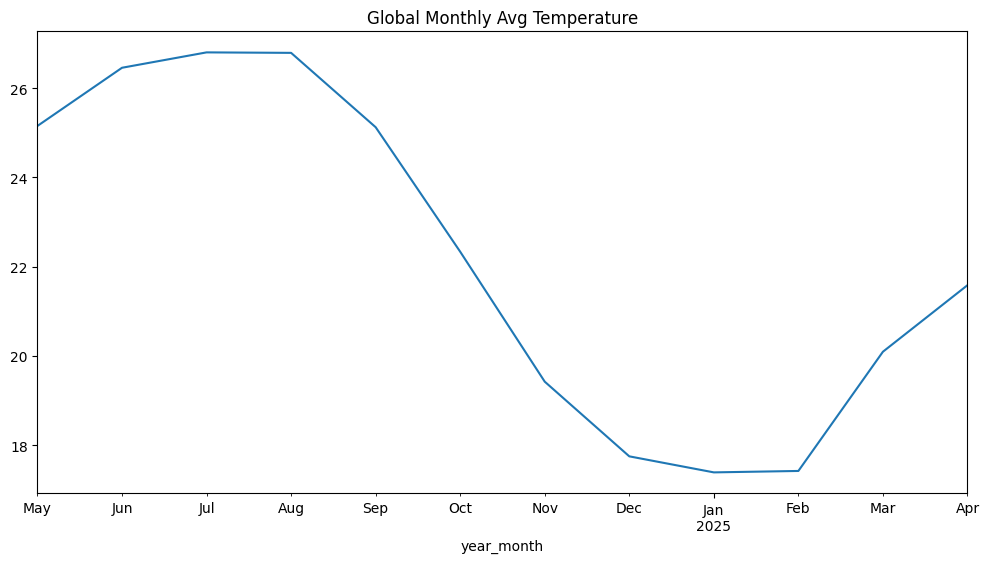

In [32]:
# Climate Analysis

#Convert 'last_updated' to datetime
df['last_updated'] = pd.to_datetime(df['last_updated'])

# Create a Year-Month column
df['year_month'] = df['last_updated'].dt.to_period('M')

#Monthly temperature trend globally
monthly_temp = df.groupby('year_month')['temperature_celsius'].mean()
monthly_temp.plot(kind='line', figsize=(12,6), title='Global Monthly Avg Temperature')


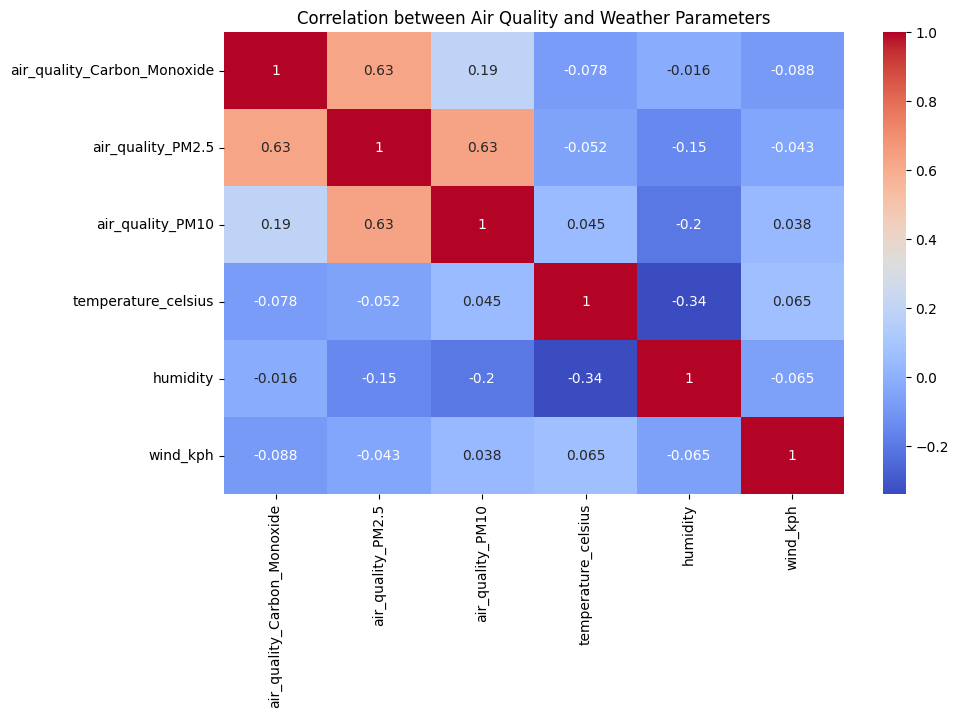

In [33]:
# Environmental Impact – Air Quality Correlation

aq_cols = [
    'air_quality_Carbon_Monoxide', 'air_quality_PM2.5', 'air_quality_PM10',
    'temperature_celsius', 'humidity', 'wind_kph'
]

# Drop NaNs
df_aq = df[aq_cols].dropna()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.heatmap(df_aq.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation between Air Quality and Weather Parameters")
plt.show()


<Axes: title={'center': 'Feature Importance on Temperature'}>

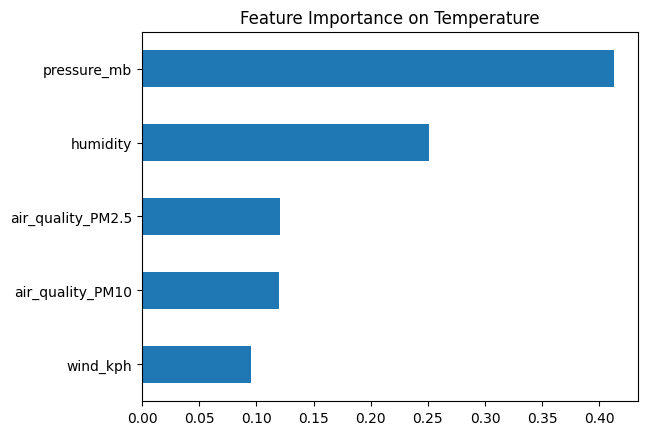

In [34]:
# Feature Importance

from sklearn.ensemble import RandomForestRegressor

features = ['humidity', 'wind_kph', 'pressure_mb', 'air_quality_PM2.5', 'air_quality_PM10']
df_feat = df.dropna(subset=features + ['temperature_celsius'])

X = df_feat[features]
y = df_feat['temperature_celsius']

model = RandomForestRegressor()
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', title='Feature Importance on Temperature')


In [35]:
# Spatial Analysis – Geographical Trends

import plotly.express as px

fig = px.scatter_geo(df,
                     lat='latitude',
                     lon='longitude',
                     color='temperature_celsius',
                     hover_name='location_name',
                     size_max=15,
                     title='Global Temperature Distribution',
                     projection='natural earth')
fig.show()


<ipython-input-36-f63566b8e03c>:6: UserWarning:

Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from font(s) DejaVu Sans.

<ipython-input-36-f63566b8e03c>:6: UserWarning:

Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 28779 (\N{CJK UNIFIED IDEOGRAPH-706B}) missing from font(s) DejaVu Sans.

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Glyph 40481 (\N{CJK UNIFIED IDEOGRAPH-9E21}) missing from font(s) DejaVu Sans.



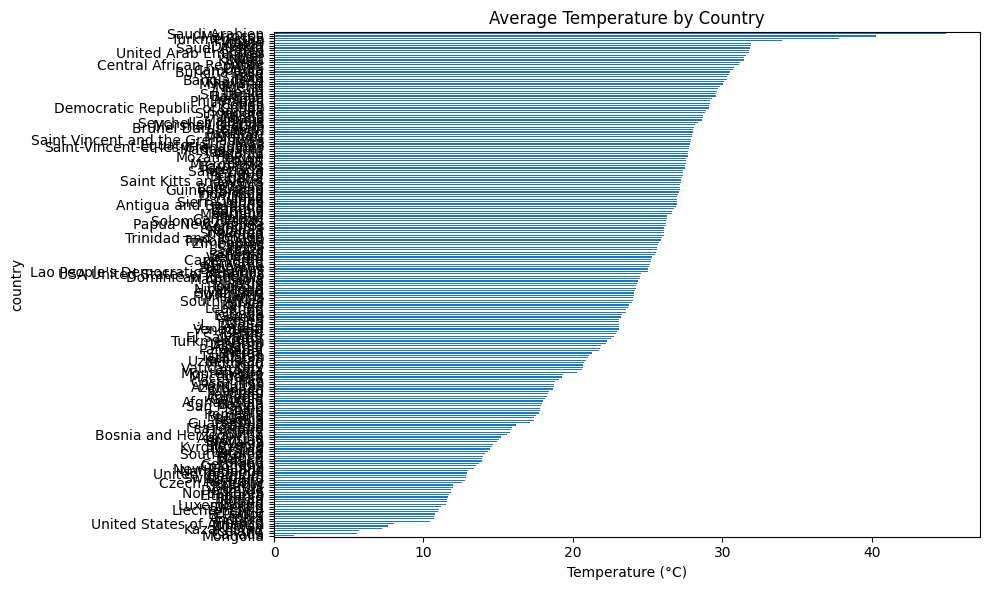

In [36]:
#Geographical Patterns (Country Comparison)

country_temp = df.groupby('country')['temperature_celsius'].mean().sort_values()

plt.figure(figsize=(10,6))
country_temp.plot(kind='barh', title='Average Temperature by Country')
plt.xlabel('Temperature (°C)')
plt.tight_layout()
plt.show()


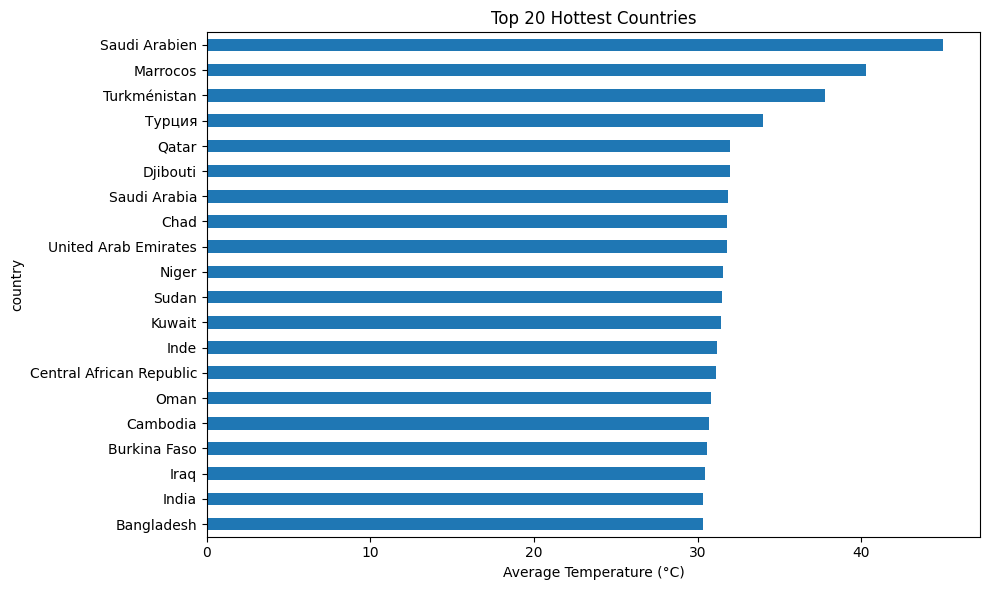

In [37]:
# Show only top N countries

top_countries = country_temp.tail(20)  # Change to .head(20) for coldest
plt.figure(figsize=(10, 6))
top_countries.plot(kind='barh', title='Top 20 Hottest Countries')
plt.xlabel('Average Temperature (°C)')
plt.tight_layout()
plt.show()


In [39]:
#interactive Plotly chart

import plotly.express as px

fig = px.bar(country_temp.reset_index(),
             x='temperature_celsius',
             y='country',
             orientation='h',
             title='Average Temperature by Country',
             height=1200)  # Adjust height to fit all labels
fig.show()
